In [1]:
from thinker.main import Env
from thinker.util import init_env_out, create_env_out
from thinker.actor_net import ActorNet
import thinker.util as util
import os
import torch

xpid = "v18_thinker_decd2b"
savedir = "/home/scuk/RS/thinker/logs/thinker/"
env_n = 8
seed = 1

ckpdir = os.path.join(savedir, xpid) 
config_path = os.path.join(ckpdir, 'config_c.yaml')
flags = util.create_flags(config_path, save_flags=False)
env = Env(
    name=flags.name,
    env_n=env_n,
    base_seed=seed,        
    gpu=False,
    train_model=False,
    parallel=False,
    savedir=savedir,        
    xpid=xpid,
    ckp=True,
    return_x=True
    )

device = env.device

actor_net = ActorNet(obs_space=env.observation_space, action_space=env.action_space, flags=flags, tree_rep_meaning=env.get_tree_rep_meaning())
checkpoint = torch.load(os.path.join(savedir, xpid, "ckp_actor.tar"))["actor_net_state_dict"]
actor_net.load_state_dict(checkpoint)
actor_net = actor_net.to(device)

env.seed(list(range(env_n)))
state = env.reset()
env_out = init_env_out(state, flags=flags, dim_actions=actor_net.dim_actions, tuple_action=actor_net.tuple_action)  
actor_state = actor_net.initial_state(batch_size=env.env_n, device=device)


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 255, (3, 80, 80), uint8) and action space Discrete(5)
Model network size: 6428938


Loaded config from /home/scuk/RS/thinker/logs/thinker/v18_thinker_decd2b/config_c.yaml


Loaded model net from /home/scuk/RS/thinker/logs/thinker/v18_thinker_decd2b/ckp_model.tar


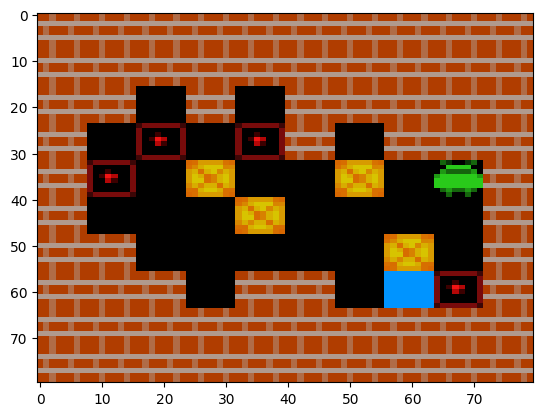

In [2]:
b = -1
state = env.reset()
util.plot_raw_state(state["real_states"][b])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


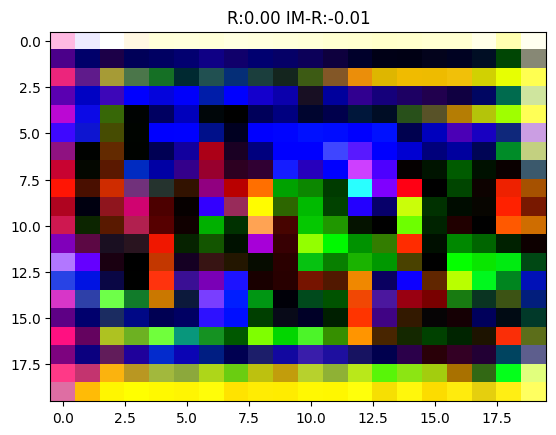

In [7]:
pri_action = torch.full((env_n,), fill_value=1, device=device, dtype=torch.long)
reset_action = torch.full((env_n,), fill_value=0, device=device, dtype=torch.long)
state, reward, done, info = env.step(pri_action, reset_action, ignore=True)
tree_rep = env.decode_tree_reps(state["tree_reps"])
util.plot_raw_state(state["xs"][b], title=f"R:{reward[b].item():.2f} IM-R:{tree_rep['cur_r'][b].item():.2f}")

In [21]:
from thinker.main import Env
from thinker.self_play import init_env_out, create_env_out
from thinker.actor_net import DRCNet, DRCNet_
from thinker.self_play import EnvOut
import torch

seed = 1
env = Env(
    env_n=3,
    name="Sokoban-v0",
    base_seed=seed,        
    gpu=False,
    wrapper_type=1,
    )
env.seed([0]*env.env_n)
flags = env.flags
flags.im_cost = 0
flags.cur_cost = 0

state = env.reset()
actor_net = DRCNet(env.observation_space, env.action_space, flags)
actor_net_ = DRCNet_(None, (3,80,80), 5, flags)

actor_net_.load_state_dict(actor_net.state_dict())

actor_state = actor_net.initial_state(batch_size=env.env_n)
actor_state_ = actor_net_.initial_state(batch_size=env.env_n)

env_out = init_env_out(state, flags=env.flags, dim_actions=actor_net.dim_actions, tuple_action=actor_net.tuple_action)  
env_outs = []
for _ in range(10):
    actor_out, actor_state = actor_net(env_out, actor_state, compute_loss=True)
    actor_out_, actor_state_ = actor_net_(env_out, actor_state_,)
    state, reward, done, info = env.step(actor_out.action, None)
    env_out = create_env_out(actor_out.action, state, reward, done, info, flags=flags)
    env_outs.append(env_out)

c_env_out = {}
for k in env_out._fields:
    c_env_out[k] = torch.concat([getattr(d, k) for d in env_outs], dim=0) if getattr(env_out, k) is not None else None
c_env_out = EnvOut(**c_env_out)


Initializing env 0 with device cpu


Symlinked log directory: /mnt/c/Users/chung/Personal/RS/thinker/notebook/logs/latest
Wrote config file to /mnt/c/Users/chung/Personal/RS/thinker/notebook/logs/thinker-20240211-150753/config_c.yaml
